In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import random
from torch.utils.data import TensorDataset, DataLoader
import time 

random_seed = 42
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) 

In [3]:
doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# assume that we live in ../data/
with open('../data/faces_python.pkl', 'rb') as f:
    face_data = pickle.load(f).astype(np.float32)
with open('../data/nonfaces_python.pkl', 'rb') as f:
    nonface_data = pickle.load(f).astype(np.float32)

In [5]:
print("face_data shape:", face_data.shape)
print("nonface_data shape:", nonface_data.shape)

face_data shape: (13233, 1024)
nonface_data shape: (50000, 1024)


In [6]:
# Normalize data
print("face_data min, max:", face_data.min(), face_data.max())
print("nonface_data min, max:", nonface_data.min(), nonface_data.max())

# [0.0, 255.0] -> [0, 1]
nonface_data /= 255.

# [0, 1] -> [-1, 1]
face_data -= 0.5
face_data *= 2

# do same as face_data
nonface_data -= 0.5
nonface_data *= 2

print("face_data min, max:", face_data.min(), face_data.max())
print("nonface_data min, max:", nonface_data.min(), nonface_data.max())

face_data min, max: 0.0 1.0
nonface_data min, max: 0.0 255.0
face_data min, max: -1.0 1.0
nonface_data min, max: -1.0 1.0


In [7]:
# split the dataset into train and test (80% and 20%)
train_test_split = 0.8

# prepare faces dataset
tmp1 = np.round(face_data.shape[0]*train_test_split).astype(int)
train_ct1 = np.ones(tmp1) 
test_ct1 = np.ones((face_data.shape[0]-tmp1,))
train_ci1 = face_data[:tmp1,:] 
test_ci1 = face_data[tmp1:,:]

# prepare non-faces dataset
# CIFAR has a lot more images, so this dataset restrict to the same number of images as the face dataset!
tmp2 = np.round(face_data.shape[0]*train_test_split).astype(int)
train_ct2 = np.zeros(tmp2) 
test_ct2 = np.zeros((face_data.shape[0]-tmp2,))
train_ci2 = nonface_data[:tmp2,:] 
test_ci2 = nonface_data[tmp2:face_data.shape[0],:]

# now concatenate arrays
train_ct12 = np.concatenate((train_ct1,train_ct2),axis=0)
train_ci12 = np.concatenate((train_ci1,train_ci2),axis=0).reshape(-1,1,32,32)

test_ct12 = np.concatenate((test_ct1,test_ct2),axis=0)
test_ci12 = np.concatenate((test_ci1,test_ci2),axis=0).reshape(-1,1,32,32)

# since we cannot use our dataset as numpy, copy them to tensor 
train_ct12 = torch.tensor(train_ct12, dtype=torch.long)
train_ci12 = torch.tensor(train_ci12, dtype=torch.float32)
test_ct12 = torch.tensor(test_ct12, dtype=torch.long)
test_ci12 = torch.tensor(test_ci12, dtype=torch.float32)


In [8]:
# make dataset and dataloader
trainset = TensorDataset(train_ci12, train_ct12)
testset = TensorDataset(test_ci12, test_ct12)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

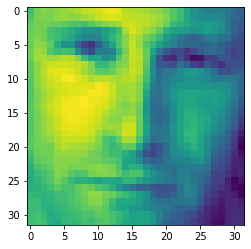

In [9]:
import matplotlib.pyplot as plt
plt.imshow(face_data[0].reshape(32,32))
plt.show()

In [10]:
# define a CNN based on the nn.Module class
class CNN(nn.Module):
    # every nn needs the constructor
    def __init__(self, num_layer, size, increase):
        # call the pytorch constructor of the parent class
        super().__init__()
        self.num_layer = num_layer
        self.size = size
        self.increase = increase
        self.padd = int(self.size/2)
        
        # define convolution layer
        self.conv1 = nn.Conv2d(1, 8, self.size, padding=self.padd)
        self.conv2 = nn.Conv2d(8, 16, self.size, padding=self.padd)
        self.conv3 = nn.Conv2d(16, 32, self.size,padding=self.padd)
        self.conv4 = nn.Conv2d(32, 64, self.size, padding=self.padd)
        self.conv5 = nn.Conv2d(1, 16, self.size, padding=self.padd)
        self.conv6 = nn.Conv2d(16, 16, self.size, padding=self.padd)

        # max pooling using 2x2 grid [downsampling]
        self.pool = nn.MaxPool2d(2, 2)

        # define fully connected layer 
        self.fc1 = nn.Linear(2 ** (self.num_layer+2) * int(32/(2**self.num_layer)) * int(32/(2**self.num_layer)), 2)
        self.fc2 = nn.Linear(16 * int(32/(2**self.num_layer)) * int(32/(2**self.num_layer)), 2)
    
    # every nn needs a forward pass function which takes data x as input and returns x as output
    # the forward function uses the layers defined in the constructor to make the network architecture
    def forward(self, x):
        if self.increase == True: # type of filter ([8, 16])
            if self.num_layer == 2:
                
                x = self.pool(F.relu(self.conv1(x))) # Relu of first convolution layer and pooling layer
                x = self.pool(F.relu(self.conv2(x))) # Relu of second convolution layer and pooling layer
                x = torch.flatten(x, 1) # flatten output so that it fits into fully connected layer (flatten all dimensions except batch)
                x = self.fc1(x)

            elif self.num_layer == 3:
                x = self.pool(F.relu(self.conv1(x)))
                x = self.pool(F.relu(self.conv2(x)))
                x = self.pool(F.relu(self.conv3(x)))
                x = torch.flatten(x, 1)
                x = self.fc1(x)

            elif self.num_layer == 4:
                x = self.pool(F.relu(self.conv1(x)))
                x = self.pool(F.relu(self.conv2(x)))
                x = self.pool(F.relu(self.conv3(x)))
                x = self.pool(F.relu(self.conv4(x)))
                x = torch.flatten(x, 1)
                x = self.fc1(x)
            else:
                print('Error')
        else : # type of filter ([16, 16])
            if self.num_layer == 2:
                x = self.pool(F.relu(self.conv5(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = torch.flatten(x, 1) 
                x = self.fc2(x)

            elif self.num_layer == 3:
                x = self.pool(F.relu(self.conv5(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = torch.flatten(x, 1)
                x = self.fc2(x)

            elif self.num_layer == 4:
                x = self.pool(F.relu(self.conv5(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = torch.flatten(x, 1)
                x = self.fc2(x)
            else:
                print('Error')
        return x


In [11]:
# we define a class for training and test algorithm
class Train_Test:
    def __init__(self, num_layer, size, b_increase):
        self.num_layer = num_layer
        self.size = size
        self.b_increase = b_increase

        self.net = CNN(self.num_layer, self.size, self.b_increase).to(device)
        self.criterion = nn.CrossEntropyLoss() # the cross entropy loss
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9) # choose SGD as optimizer 
        self.running_loss = []
        self.acc = 0
        
    # define a training function
    def training(self):
        start_time = time.time()
        for epoch in range(10):  # loop over the dataset 10 times
            # load a batch of data
            for inputs, labels in train_loader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = inputs.to(device), labels.to(device)
                
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + loss + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                self.running_loss.append(loss.item())
                
        end_time = time.time()
        self.training_time = end_time - start_time
    
    # define a test function
    def test(self):       
        # again no gradients needed
        with torch.no_grad():
            number_correct = 0
            # go through all elements in the test set
            for inputs, labels in test_loader:
                # again push them to device
                inputs, labels = inputs.to(device), labels.to(device)
                # we need the forward pass
                outputs = self.net(inputs)
                output_label = outputs.argmax(dim=1)
                number_correct += (output_label == labels).sum().item()
                
            self.acc = number_correct / len(testset)
    # define a plot function to show the results
    def draw_plot(self):
        filter_list = [[8, 16, 32, 64], [16, 16, 16, 16]]

        print('number of layers : ', self.num_layer)
        print('number of filters : ', filter_list[self.b_increase][:self.num_layer])
        print('size of filters : ', self.size, 'x', self.size)
        print('total training time : %d s' %(self.training_time))
        print('final accuracy : {:.0%}'.format(self.acc))
        
        plt.plot(self.running_loss)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss curves')
        plt.show()
    

In [13]:
# assign the layer, number of filters and filter size
layer_list = [2, 3, 4]
b_filter = [0, 1]
size_list = [3, 5]

all_network = [] # make a array to save the results for each network
for num_lay in layer_list:
    for bo_fil in b_filter:
        for size in size_list:
            all_network.append(Train_Test(num_lay, size, bo_fil))


number of layers :  2
number of filters :  [8, 16]
size of filters :  3 x 3
total training time : 6 s
final accuracy : 98%


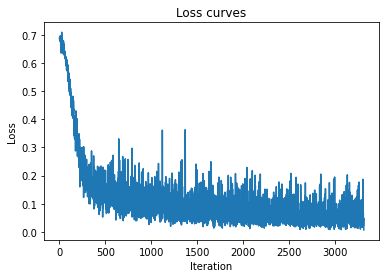

number of layers :  2
number of filters :  [8, 16]
size of filters :  5 x 5
total training time : 6 s
final accuracy : 99%


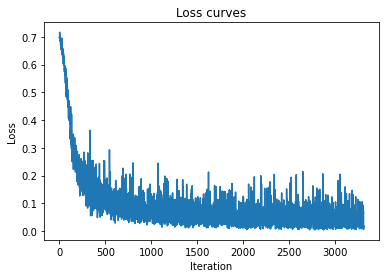

number of layers :  2
number of filters :  [16, 16]
size of filters :  3 x 3
total training time : 6 s
final accuracy : 98%


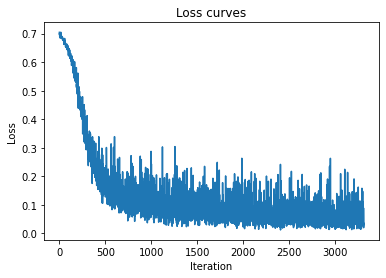

number of layers :  2
number of filters :  [16, 16]
size of filters :  5 x 5
total training time : 6 s
final accuracy : 99%


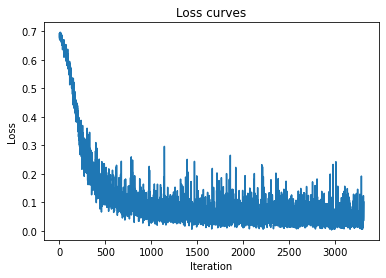

number of layers :  3
number of filters :  [8, 16, 32]
size of filters :  3 x 3
total training time : 7 s
final accuracy : 98%


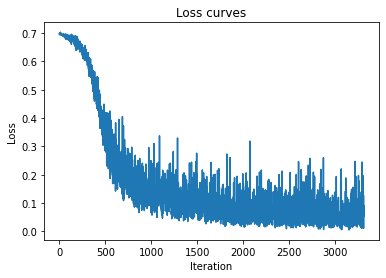

number of layers :  3
number of filters :  [8, 16, 32]
size of filters :  5 x 5
total training time : 7 s
final accuracy : 99%


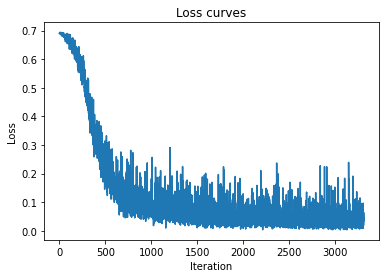

number of layers :  3
number of filters :  [16, 16, 16]
size of filters :  3 x 3
total training time : 7 s
final accuracy : 98%


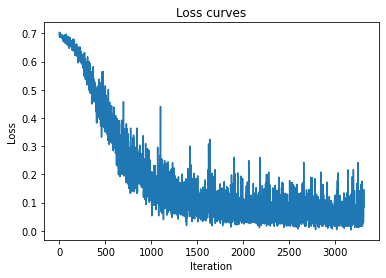

number of layers :  3
number of filters :  [16, 16, 16]
size of filters :  5 x 5
total training time : 7 s
final accuracy : 99%


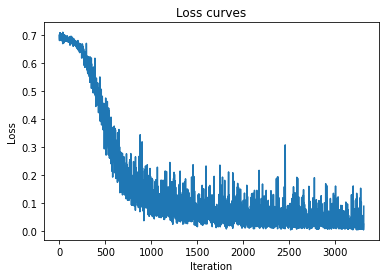

number of layers :  4
number of filters :  [8, 16, 32, 64]
size of filters :  3 x 3
total training time : 8 s
final accuracy : 97%


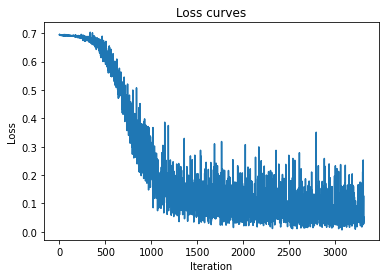

number of layers :  4
number of filters :  [8, 16, 32, 64]
size of filters :  5 x 5
total training time : 8 s
final accuracy : 99%


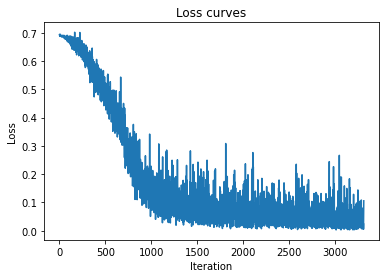

number of layers :  4
number of filters :  [16, 16, 16, 16]
size of filters :  3 x 3
total training time : 8 s
final accuracy : 98%


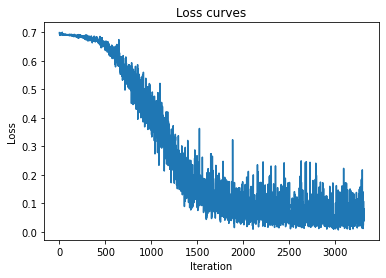

number of layers :  4
number of filters :  [16, 16, 16, 16]
size of filters :  5 x 5
total training time : 9 s
final accuracy : 99%


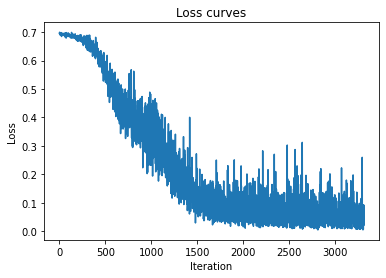

In [14]:
# do computation then plot the result 
for network in all_network:
    network.training()
    network.test()
    network.draw_plot()
    

# Discussion
All the experiments are trained on NVIDIA Titan XP as single GPU.\
According to 12 plots from 12 different networks, we can see that the more layers we use, the more training time we need because more layers need more convolution process which implies taking more time to train the network.
Also, training the network with a bigger filter size takes more training time than a smaller one when the other conditions are given same. This is because the bigger filter size has more pixels than the smaller one, the more pixel calculation required than the smaller one for each image. Instead of longer training time, we have an advantage of higher accuracy.
For loss curves from 12 networks, The loss drops slowly as number of layers increase. we can also see that networks with bigger filter size shows more stable loss fluctuation than that of smaller one.
So, the best network among these networks would be 2 layers with 8 and 16 filters for each layer as filter size of 5. The reason is that this network shows the shortest training time and the highest accuracy among these networks. According to this network loss curve, the loss drops quickly until 500 iteration and then shows stable loss fluctuation. 
